# NCEI Access API Wrapper

Welcome to the `ncei_access` package where you can retrieve and analyze weather data from NOAA's National Centers for Environmental Information (NCEI) Access API! The [official documentation](https://www.ncei.noaa.gov/access-search) from the NCEI is pretty lackluster and there are probably some ways in which they throttle users but who knows! I also have no idea how reliable the API is. Caveat emptor.

## Overview

The `ncei_access` package provides a convenient interface for:
- Finding weather stations by ID, location, or boundaries
- Retrieving daily weather data (temperature, snow depth, etc.)
- Working with weather station metadata

## Installation and Setup

First, let's import the necessary packages and create an instance of the NceiAccessor class:

In [1]:
# Create an instance of the NceiAccessor class to go weather-data-hunting.
from ncei_access import ncei_accessor as na
ncei_db = na.NceiAccessor()

## Finding Weather Stations

### 1. Find Station by ID

If you know the station ID, you can directly retrieve station information. In this example, we'll look up the Mill D North station in Big Cottonwood Canyon, Utah (near Salt Lake City).

In [2]:
mill_d = ncei_db.find_station("USS0011J65S")

print(f"Station name: {mill_d.name}")
print(f"Station ID: {mill_d.station_id}")
print(f"Station latitude: {mill_d.lat}")
print(f"Station longitude: {mill_d.lon}")
# print(f"Station elevation: {mill_d.elevation()}")  # See docs for the hackiness of this method
print(f"Recorded datatypes at station: {mill_d.data_types}")  # easier to read in a pandas DataFrame
print(f"Does station record TMAX data type?: {mill_d.has_data_type('TMAX')}")

Station name: MILL D NORTH, UT US
Station ID: USS0011J65S
Station latitude: 40.66
Station longitude: -111.64
Recorded datatypes at station: [{'coverage': 99.33507170795306, 'endDate': '2025-06-21T23:59:59', 'dateRange': {'start': '2004-06-21T00:00:00', 'end': '2025-06-21T23:59:59'}, 'searchWeight': 1, 'id': 'TMAX', 'startDate': '2004-06-21T00:00:00'}, {'coverage': 100.0, 'endDate': '2025-06-21T23:59:59', 'dateRange': {'start': '1988-09-30T00:00:00', 'end': '2025-06-21T23:59:59'}, 'searchWeight': 1, 'id': 'WESD', 'startDate': '1988-09-30T00:00:00'}, {'coverage': 99.29595827900913, 'endDate': '2025-06-21T23:59:59', 'dateRange': {'start': '2004-06-21T00:00:00', 'end': '2025-06-21T23:59:59'}, 'searchWeight': 1, 'id': 'TAVG', 'startDate': '2004-06-21T00:00:00'}, {'coverage': 99.29595827900913, 'endDate': '2025-06-21T23:59:59', 'dateRange': {'start': '2004-06-21T00:00:00', 'end': '2025-06-21T23:59:59'}, 'searchWeight': 1, 'id': 'TMIN', 'startDate': '2004-06-21T00:00:00'}, {'coverage': 100.0,

### 2. Find Stations by Geographic Boundaries

You can also search for all stations within a specific rectangular area defined by latitude and longitude boundaries. Here we find all stations between latitudes 41°N and 40.5°N and between longitudes -111°W and -110.5°W. This is a rectangle that captures the top of the Mirror Lake Highway in Utah, USA.

In [3]:
stations_in_boundary_test = ncei_db.stations_in_boundary(41, -111, 40.5, -110.5)

# Returns a list of Station objects, which we can iterate over to see the details.
print(f"Found {len(stations_in_boundary_test)} stations in the specified boundary:")
for station in stations_in_boundary_test:
    print(f"Station name: {station.name} --- Station ID: {station.station_id}")

Found 13 stations in the specified boundary:
Station name: TRIAL LAKE, UT US --- Station ID: USS0010J52S
Station name: BURTS MILLER RANCH, UT US --- Station ID: USS0010J06S
Station name: BEAR RIVER RANGER STATION, UT US --- Station ID: USS0010J17S
Station name: ROCK CREEK, UT US --- Station ID: USS0010J18S
Station name: STEEL CREEK PARK, UT US --- Station ID: USS0010J20S
Station name: EF BLACKS FORK GS, UT US --- Station ID: USS0010J21S
Station name: BLACKS FORK JCT, UT US --- Station ID: USS0010J22S
Station name: BUCK PASTURE, UT US --- Station ID: USS0010J23S
Station name: BROWN DUCK, UT US --- Station ID: USS0010J30S
Station name: LILY LAKE, UT US --- Station ID: USS0010J35S
Station name: HAYDEN FORK, UT US --- Station ID: USS0010J44S
Station name: BEAR RIVER UTAH, UT US --- Station ID: USR0000BEAR
Station name: BLACKS FORK COMMISSARY, UT US --- Station ID: USC00420734


### 3. Find Closest Station to a Point

And, lastly, you can find the weather station closest to any given latitude and longitude. Let's find the closest station to the second highest mountain in Utah, Mt Peale.

In [4]:
closest_to_peale = ncei_db.find_closest_station(38.438212, -109.228878)  # Mt Peale, UT
print(f"Closest station to Mt Peale: {closest_to_peale.name} --- Station ID: {closest_to_peale.station_id}")

Closest station to Mt Peale: LASAL MOUNTAIN, UT US --- Station ID: USS0009L03S


## Retrieving Weather Data
Say we have a station we're interested in and we now want to get some data. For example, the weather station at Mill D North is a SNOTEL site that records daily snow depth (SNWD). Let's get the daily snow depth since January 1, 2023:

In [5]:
# Get daily snow depth data
mill_d_sd = ncei_db.get_daily(
    data_types=["SNWD"],  # Snow depth
    stations=mill_d.station_id,  # Station ID
    start="2023-01-01",  # Start date for the data
)

This will return a list of dictionaries, each containing the date and the snow depth for that date. Let's convert this to a pandas DataFrame for easier manipulation:

In [29]:
import pandas as pd
mill_d_sd_df = pd.DataFrame(mill_d_sd).dropna()
print(mill_d_sd_df.head().to_markdown(index=False))

| DATE       | STATION     |   SNWD |
|:-----------|:------------|-------:|
| 2023-01-01 | USS0011J65S |   1829 |
| 2023-01-02 | USS0011J65S |   1753 |
| 2023-01-03 | USS0011J65S |   1727 |
| 2023-01-04 | USS0011J65S |   1676 |
| 2023-01-05 | USS0011J65S |   1727 |


### Understanding Data Types and Units

Great! But what the hell are the units? We can look up the data type reference to find out. The data type reference is a dictionary that maps data type IDs to their names and units.

In [7]:
from ncei_access import dataType_ref
print(dataType_ref["SNWD"].__dict__)

{'id': 'SNWD', 'name': 'Snow depth (mm)', 'units': 'millimeters', 'metric_output_units': 'millimeters', 'metric_output_precision': 1, 'standard_output_units': 'inches', 'standard_output_precision': 1, 'scale_factor': 1, 'scale_weight': None}


This shows us that the units are in millimeters (mm) and that the scale factor is 1 which means the values are in mm directly. Let's convert the date column to a datetime format and the snow depth to a float.

In [33]:
mill_d_sd_df = mill_d_sd_df.astype({"DATE": "datetime64[s]", "SNWD": float})
mill_d_sd_df["SNWD"] = mill_d_sd_df["SNWD"] / 10  # Convert from mm to cm
print(mill_d_sd_df.head().to_markdown(index=False))

| DATE                | STATION     |   SNWD |
|:--------------------|:------------|-------:|
| 2023-01-01 00:00:00 | USS0011J65S |  18.29 |
| 2023-01-02 00:00:00 | USS0011J65S |  17.53 |
| 2023-01-03 00:00:00 | USS0011J65S |  17.27 |
| 2023-01-04 00:00:00 | USS0011J65S |  16.76 |
| 2023-01-05 00:00:00 | USS0011J65S |  17.27 |


### Getting Daily High and Low Temperatures

I created this API wrapper because I was most interested in daily high and low temperatures. So I created a convenience function to get daily high and low temperatures for a specific station. Let's use the station we found earlier, Mill D North, and get the daily high and low temperatures since January 1, 2023:

In [34]:
mill_d_hilow = ncei_db.get_daily_hilow(
    stations=mill_d.station_id,  # Station ID
    start="2023-01-01",  # Start date for the data
)

# Convert to pandas DataFrame for easier manipulation
mill_d_hilow_df = pd.DataFrame(mill_d_hilow).dropna()
print(mill_d_hilow_df.head().to_markdown(index=False))

| DATE       | STATION     |   TMAX |   TMIN |
|:-----------|:------------|-------:|-------:|
| 2023-01-01 | USS0011J65S |     -1 |    -81 |
| 2023-01-02 | USS0011J65S |    -53 |   -101 |
| 2023-01-03 | USS0011J65S |    -55 |   -111 |
| 2023-01-04 | USS0011J65S |     -3 |   -111 |
| 2023-01-05 | USS0011J65S |    -10 |    -57 |


### Understanding Temperature Data Units

Looking at the TMAX and TMIN columns, we can see that the range of temperatures is not what we would expect (daily minimums of -111\deg???). Let's inspect the data type reference for TMAX and TMIN to see what it has to say:

In [10]:
print("Daily maximum temperature (TMAX) data type reference:")
print(dataType_ref["TMAX"].__dict__)
print("\nDaily minimum temperature (TMIN) data type reference:")
print(dataType_ref["TMIN"].__dict__)

Daily maximum temperature (TMAX) data type reference:
{'id': 'TMAX', 'name': 'Maximum temperature (tenths of degrees C)', 'units': 'celsius', 'metric_output_units': 'celsius', 'metric_output_precision': 1, 'standard_output_units': 'fahrenheit', 'standard_output_precision': 0, 'scale_factor': 0.1, 'scale_weight': None}

Daily minimum temperature (TMIN) data type reference:
{'id': 'TMIN', 'name': 'Minimum temperature (tenths of degrees C)', 'units': 'celsius', 'metric_output_units': 'celsius', 'metric_output_precision': 1, 'standard_output_units': 'fahrenheit', 'standard_output_precision': 0, 'scale_factor': 0.1, 'scale_weight': None}


Note that the scale factor is 0.1 for both TMAX and TMIN, which means the values are actually in tenths of degrees Celsius. Let's convert the TMAX and TMIN columns to float and then divide by 10 to get the actual temperatures in degrees Celsius:

In [32]:
mill_d_hilow_df = mill_d_hilow_df.astype(
    {"DATE": "datetime64[s]", "TMAX": float, "TMIN": float}
)
mill_d_hilow_df["TMAX"] = mill_d_hilow_df["TMAX"] / 10
mill_d_hilow_df["TMIN"] = mill_d_hilow_df["TMIN"] / 10
print(mill_d_hilow_df.head().to_markdown(index=False))

| DATE                | STATION     |   TMAX |   TMIN |
|:--------------------|:------------|-------:|-------:|
| 2023-01-01 00:00:00 | USS0011J65S |   -0.1 |   -8.1 |
| 2023-01-02 00:00:00 | USS0011J65S |   -5.3 |  -10.1 |
| 2023-01-03 00:00:00 | USS0011J65S |   -5.5 |  -11.1 |
| 2023-01-04 00:00:00 | USS0011J65S |   -0.3 |  -11.1 |
| 2023-01-05 00:00:00 | USS0011J65S |   -1   |   -5.7 |


### Plotting Temperature Data

Those values make more sense now. Let's plot the daily high and low temperatures using Plotly Express.

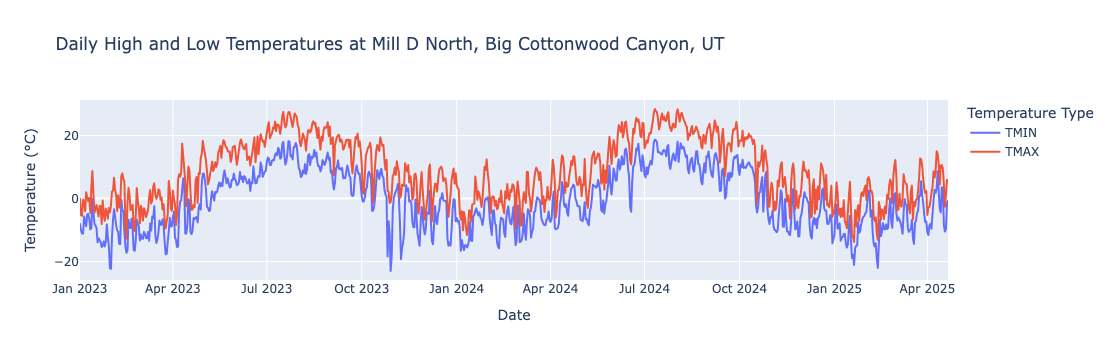

In [12]:
import plotly.express as px
fig = px.line(
    mill_d_hilow_df,
    x="DATE",
    y=["TMIN", "TMAX"],
    labels={"value": "Temperature (°C)", "variable": "Temperature Type"},
    title="Daily High and Low Temperatures at Mill D North, Big Cottonwood Canyon, UT",
)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    legend_title="Temperature Type",
)
fig.show()

## Example Analysis

At this point, we can start doing some analysis on the data. For example, to inspect the relationship between temperatures and snow depth we could do the following: Join the snow depth and temperature dataframes on date.

In [13]:
mill_d_combined_df = pd.merge(
    mill_d_sd_df, mill_d_hilow_df, on=["DATE", "STATION"], how="inner"
)

And let's subset the data to just the winter and spring months of the 2023/2024 season to make the graph I'm thinking of making easier to look at:

In [14]:
winter_2024 = mill_d_combined_df[
    (mill_d_combined_df["DATE"] >= "2023-12-01")
    & (mill_d_combined_df["DATE"] < "2024-05-01")
].copy()

And now we can create a plot showing both temperature and snow depth on the same chart with dual y-axes:

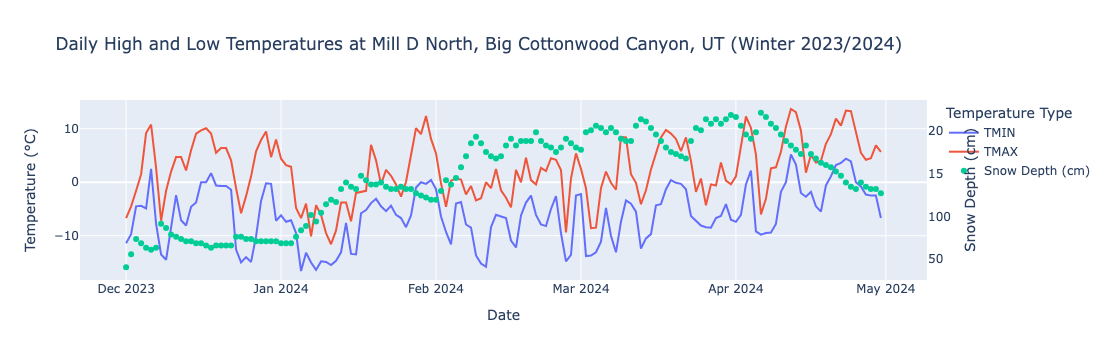

In [15]:
fig = px.line(
    winter_2024,
    x="DATE",
    y=["TMIN", "TMAX"],
    labels={"value": "Temperature (°C)", "variable": "Temperature Type"},
    title="Daily High and Low Temperatures at Mill D North, Big Cottonwood Canyon, UT (Winter 2023/2024)",
)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    legend_title="Temperature Type",
)

# Add snow depth on secondary y-axis
fig.add_scatter(
    x=winter_2024["DATE"],
    y=winter_2024["SNWD"],
    mode="markers",
    name="Snow Depth (cm)",
    yaxis="y2",  # Use a secondary y-axis for snow depth
)

fig.update_layout(
    yaxis2=dict(
        title="Snow Depth (cm)",
        overlaying="y",
        side="right",
        showgrid=False,
        zeroline=False,
    )
)

fig.show()

And you can start to see that when the temperatures get high, then the snow depth starts to decrease and when temps get low, the snow depth seems to go up. And then we could calculate the **change** in snowdepth relative to temperature and blah, blah, blah. This is just the README file right? It shows how you can use the ncei_access package to get weather data and start doing your own analysis.